### Section 1: Pilot

### Pilot scope (intentional)
This notebook is intentionally scoped to a **Santa Cruz bounding box** for the **2022 fire season**.

Why start here?
- Validate data pipelines (CAL FIRE FRAP perimeters + Open‑Meteo) end-to-end.
- Validate modeling choices (features, label definition, thresholds).
- Validate evaluation under class imbalance.
- Validate interpretation (what the probability output *means*).

In this pilot, “high readiness risk” means **readiness should be elevated** because:
- there are **nearby fire perimeters** (low distance-to-fire, computed dynamically per day), **AND**
- conditions are **windy/dry** (higher wind and higher evap proxy), with
- limited precipitation.

**Important:** High risk (class 2) requires **both** close proximity (≤10km) **and** adverse weather conditions. Close proximity alone results in elevated risk (class 1), not high risk.

Before scaling, we validate that these trends are physically plausible for Central Coast wildfire behavior.

### Generalization caveat
This model is **not expected to generalize** outside Santa Cruz 2022 without retraining or recalibration.

**Note:** Output should not be used to reflect exterior conditions until retrained/recalibrated.

Labeling rules are heuristic and context dependent.

**Model evaluation/interpretation:** Logistic regression would be recommended for pilot tool given ROC-AUC and recall performance. 

In [19]:
# =======================
# CONFIGURATION (Pilot)
# =======================
# These parameters define the Santa Cruz pilot scope.
# To expand beyond the pilot, update these values and re-run the dataset build.

HOME_LAT, HOME_LON = 36.9741, -122.0308  # Santa Cruz, CA (approx city center)

# Regional bounding box (west, south, east, north) in degrees.
# Keep this tight enough to represent the pilot region, but wide enough to capture nearby fires.
BBOX = (
    -122.35,  # west
    36.80,    # south
    -121.60,  # east
    37.30     # north
)

# Pilot time window (2022 fire season)
START_DATE = "2022-06-01"
END_DATE   = "2022-10-31"


## Evaluation priorities

For this pilot, **recall on the “high-risk / elevated-risk” class is the primary metric**.

- **Why recall first:** A *false negative* means the model fails to flag a day that is actually elevated risk. In a wildfire readiness context, missing a dangerous day is typically more costly than raising an extra alert.
- **Why precision alongside recall:** A *false positive* means extra warnings or unnecessary readiness actions. Precision helps us track alert fatigue and operational cost.
- **Why accuracy and ROC AUC are secondary:** Accuracy can look “good” when low-risk days dominate (class imbalance). ROC AUC is useful for comparing ranking quality, but it is less intuitive for operational decisions than “did we catch the risky days?”


## Role of each model in this notebook

- **Logistic Regression (primary):** baseline model used for the main benchmark because it is stable, fast, and gives clear feature directionality.
- **Decision Tree (interpretability):** included to provide simple, human-readable rules that help explain *why* a prediction happens.
- **Random Forest (comparison):** included as a stronger nonlinear baseline to compare performance and feature importance against the simpler models.


In [ ]:
"""
build_training_data_perimeters_openmeteo.py  (Santa Cruz Pilot)

Creates a training CSV with:
- Batched Open-Meteo *archive* daily weather (historical)
- Historical fire perimeters (CAL FIRE / FRAP or any perimeter GeoJSON you provide)
  used to compute distance-to-perimeter (a stable proxy for wildfire proximity risk)

Output:
  ai_model_training_data_real_from_apis.csv
"""

from __future__ import annotations

import os
import json
import math
from dataclasses import dataclass
from datetime import date, timedelta, datetime
from pathlib import Path

import numpy as np
import pandas as pd
import requests

import geopandas as gpd
from shapely.geometry import Point

# =======================
# CONFIGURATION (Pilot)
# =======================

@dataclass(frozen=True)
class RegionConfig:
    name: str
    home_lat: float
    home_lon: float
    bbox: tuple[float, float, float, float]  # (west, south, east, north)
    start_date: date
    end_date: date
    year: int

cfg_sc = RegionConfig(
    name="Santa_Cruz_Pilot_2022",
    home_lat=36.9741,
    home_lon=-122.0308,
    bbox=(-122.35, 36.85, -121.50, 37.35),
    start_date=date(2022, 6, 1),
    end_date=date(2022, 10, 31),
    year=2022,
)

# Where we cache API responses / downloads
CACHE_DIR = Path("api_cache")
WEATHER_CACHE_DIR = CACHE_DIR / "open_meteo"
PERIM_CACHE_DIR  = CACHE_DIR / "perimeters"
WEATHER_CACHE_DIR.mkdir(parents=True, exist_ok=True)
PERIM_CACHE_DIR.mkdir(parents=True, exist_ok=True)

OUTPUT_CSV = Path("ai_model_training_data_real_from_apis.csv")

# ---- Perimeters source ----
# Option A (recommended): set this to a local perimeter file you downloaded once (GeoJSON or Shapefile).
# Example: CALFIRE FRAP fire perimeters for 2022 (or multi-year) exported as GeoJSON.
LOCAL_PERIMETERS_PATH = None  # e.g. "data/calfire_perimeters_2022.geojson"

# Option B: provide a URL to a perimeter GeoJSON (downloaded & cached automatically).
# Using CAL FIRE FRAP perimeters (same as Phase 3)
PERIMETERS_GEOJSON_URL = (
    "https://gis.data.cnra.ca.gov/api/download/v1/items/"
    "c3c10388e3b24cec8a954ba10458039d/geojson?layers=0"
)

NO_FIRE_DISTANCE_KM = 1000.0

# =======================
# Utilities
# =======================

def log(msg: str) -> None:
    ts = datetime.now().strftime("%H:%M:%S")
    print(f"[{ts}] {msg}")

def daterange(start: date, end: date):
    d = start
    while d <= end:
        yield d
        d += timedelta(days=1)

def open_meteo_cache_path(cfg: RegionConfig) -> Path:
    return WEATHER_CACHE_DIR / f"open_meteo_{cfg.name}_{cfg.start_date.isoformat()}_{cfg.end_date.isoformat()}.csv"

# =======================
# Weather: Open-Meteo archive (batched)
# =======================

def fetch_open_meteo_batched(cfg: RegionConfig, batch_days: int = 14) -> pd.DataFrame:
    cache = open_meteo_cache_path(cfg)
    if cache.exists():
        log(f"[{cfg.name}] Open-Meteo cache hit")
        df = pd.read_csv(cache)
        # Ensure date is date type (not string or datetime)
        if "date" in df.columns:
            df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.date
        return df

    log(f"[{cfg.name}] Fetching Open-Meteo archive (batched)")
    base = "https://archive-api.open-meteo.com/v1/archive"

    all_rows = []
    start = cfg.start_date
    while start <= cfg.end_date:
        end = min(cfg.end_date, start + timedelta(days=batch_days - 1))
        params = {
            "latitude": cfg.home_lat,
            "longitude": cfg.home_lon,
            "start_date": start.isoformat(),
            "end_date": end.isoformat(),
            "daily": "temperature_2m_max,precipitation_sum,windspeed_10m_max,et0_fao_evapotranspiration",
            "timezone": "UTC",
        }
        r = requests.get(base, params=params, timeout=60)
        r.raise_for_status()
        js = r.json()
        daily = js.get("daily", {})

        dates = daily.get("time", [])
        tmax  = daily.get("temperature_2m_max", [])
        prcp  = daily.get("precipitation_sum", [])
        wind  = daily.get("windspeed_10m_max", [])
        evap  = daily.get("et0_fao_evapotranspiration", [])

        for i in range(len(dates)):
            all_rows.append({
                "date": dates[i],
                "TMAX": tmax[i] if i < len(tmax) else np.nan,   # °C
                "PRCP": prcp[i] if i < len(prcp) else np.nan,   # mm
                "AWND": wind[i] if i < len(wind) else np.nan,   # km/h (Open-Meteo daily max)
                "EVAP": evap[i] if i < len(evap) else np.nan,   # mm
            })

        start = end + timedelta(days=1)

    df = pd.DataFrame(all_rows)
    df["date"] = pd.to_datetime(df["date"]).dt.date
    df.to_csv(cache, index=False)
    log(f"[{cfg.name}] Open-Meteo saved: {cache}")
    return df

# =======================
# Perimeters: load once (no FIRMS)
# =======================

def load_perimeters_for_year(cfg: RegionConfig) -> gpd.GeoDataFrame:
    """Load historical fire perimeter polygons and filter to the pilot bbox/year."""
    # 1) Prefer local file if provided
    if LOCAL_PERIMETERS_PATH:
        path = Path(LOCAL_PERIMETERS_PATH)
        if not path.exists():
            raise FileNotFoundError(f"LOCAL_PERIMETERS_PATH not found: {path}")
        gdf = gpd.read_file(path)
    else:
        # 2) Else download a GeoJSON if URL is provided
        if not PERIMETERS_GEOJSON_URL:
            raise ValueError(
                "No perimeter source configured. Set LOCAL_PERIMETERS_PATH to a local GeoJSON/Shapefile, "
                "or set PERIMETERS_GEOJSON_URL to a downloadable GeoJSON for the target year."
            )
        cache = PERIM_CACHE_DIR / f"perimeters_{cfg.year}.geojson"
        if cache.exists():
            try:
                gdf = gpd.read_file(cache)
                # Verify the file is valid (has geometry column)
                if "geometry" not in gdf.columns or len(gdf) == 0:
                    raise ValueError("Cached file is invalid or empty")
            except Exception as e:
                log(f"[{cfg.name}] Cached file corrupted or invalid: {e}. Re-downloading...")
                cache.unlink()  # Delete corrupted cache
                # Fall through to download
        else:
            log(f"[{cfg.name}] Downloading perimeters GeoJSON (cached)")
        
        if not cache.exists():
            r = requests.get(PERIMETERS_GEOJSON_URL, timeout=120)
            r.raise_for_status()
            cache.write_bytes(r.content)
            log(f"[{cfg.name}] Downloaded and cached: {cache}")
            gdf = gpd.read_file(cache)

    # Ensure WGS84
    if gdf.crs is None:
        gdf = gdf.set_crs("EPSG:4326", allow_override=True)
    else:
        gdf = gdf.to_crs("EPSG:4326")

    # Filter to bbox (fast)
    w, s, e, n = cfg.bbox
    try:
        gdf = gdf.cx[w:e, s:n]
    except Exception:
        pass

    # OPTIONAL year filtering: try common fields; if none exist, we keep bbox-filtered perimeters.
    year = cfg.year
    log(f"[{cfg.name}] Before year filtering: {len(gdf)} perimeters")
    candidates = ["YEAR_", "YEAR", "year", "FireYear", "FIRE_YEAR", "FIREYEAR"]
    year_col_found = False
    for col in candidates:
        if col in gdf.columns:
            log(f"[{cfg.name}] Found year column: {col}")
            before_count = len(gdf)
            gdf = gdf[gdf[col].astype(str).str.contains(str(year), na=False)]
            log(f"[{cfg.name}] After year filtering ({col}={year}): {len(gdf)} perimeters (was {before_count})")
            year_col_found = True
            break
    if not year_col_found:
        log(f"[{cfg.name}] No year column found, keeping all bbox-filtered perimeters")

    # Extract start_date for temporal filtering (like Phase 3)
    date_col_candidates = [
        "ALARM_DATE", "alarm_date", "DATE_", "DATE", "STARTDATE", "START_DATE",
        "IGNITION", "IGNITION_DATE", "perimeterdatetime", "PERIMETERDATETIME",
        "FireDiscoveryDateTime", "DISCOVERY", "DISCOVERY_DATE"
    ]
    for col in date_col_candidates:
        if col in gdf.columns:
            gdf["start_date"] = pd.to_datetime(gdf[col], errors="coerce").dt.date
            break
    else:
        # If no date column found, set start_date to None (will use all perimeters)
        gdf["start_date"] = pd.NaT

    gdf = gdf[gdf.geometry.notna()].copy()
    gdf = gdf[gdf.geometry.is_empty == False].copy()
    log(f"[{cfg.name}] Perimeters loaded: {len(gdf)} features after bbox/year filtering")
    
    # Diagnostic: Check if we have any perimeters
    if len(gdf) == 0:
        log(f"[{cfg.name}] WARNING: No perimeters found after filtering!")
        log(f"[{cfg.name}] Bbox: {cfg.bbox}, Year: {cfg.year}")
        log(f"[{cfg.name}] Original columns: {list(gdf.columns) if len(gdf) > 0 else 'N/A'}")
    
    return gdf

def min_distance_km_to_perimeters(lat: float, lon: float, perims_4326: gpd.GeoDataFrame) -> float:
    """Min distance from point to any perimeter polygon (km)."""
    if perims_4326 is None or len(perims_4326) == 0:
        return NO_FIRE_DISTANCE_KM

    # California Albers (meters) for distance
    perims = perims_4326.to_crs("EPSG:3310")
    pt = gpd.GeoSeries([Point(lon, lat)], crs="EPSG:4326").to_crs("EPSG:3310").iloc[0]
    dists_m = perims.geometry.distance(pt)
    if len(dists_m) == 0 or dists_m.isna().all():
        return NO_FIRE_DISTANCE_KM
    return float(dists_m.min() / 1000.0)

# =======================
# Risk labeling (simple, interpretable; tunable)
# =======================

def compute_risk_level(distance_km: float, tmax_c: float, awnd_kmh: float, prcp_mm: float, evap_mm: float) -> int:
    """
    Returns 0 (low), 1 (elevated), 2 (high) readiness.
    
    SCIENTIFIC FIX: Class 2 (high) now requires BOTH close distance AND adverse weather.
    This prevents entire regions from being locked into class 2 based solely on static distance.
    """
    if np.isnan(distance_km):
        distance_km = NO_FIRE_DISTANCE_KM

    # High (2): VERY close AND adverse weather conditions (windy/dry/hot)
    # If distance is close but weather is not adverse, default to elevated (1)
    if distance_km <= 10 and (awnd_kmh >= 20) and (evap_mm >= 4) and (prcp_mm <= 1):
        return 2
    if distance_km <= 25 and (awnd_kmh >= 25) and (evap_mm >= 4) and (prcp_mm <= 1):
        return 2
    
    # If very close but weather is not adverse, treat as elevated (not high)
    if distance_km <= 10:
        return 1

    # Elevated: moderately close OR hot/dry/windy combo
    if distance_km <= 50:
        return 1
    if (tmax_c >= 32) and (awnd_kmh >= 20) and (evap_mm >= 4) and (prcp_mm <= 1):
        return 1

    return 0

# =======================
# Build dataset (Santa Cruz pilot)
# =======================

def build_dataset(cfg: RegionConfig) -> pd.DataFrame:
    log(f"[{cfg.name}] Starting dataset build (NO FIRMS)")
    meteo = fetch_open_meteo_batched(cfg)
    log(f"[{cfg.name}] Weather data: {len(meteo)} days")
    perims = load_perimeters_for_year(cfg)
    log(f"[{cfg.name}] Perimeters loaded: {len(perims)} total")

    rows = []
    days_with_weather = 0
    days_with_perims = 0
    
    # Ensure date column is date type for comparison
    if "date" in meteo.columns:
        if meteo["date"].dtype == 'object' or pd.api.types.is_string_dtype(meteo["date"]):
            meteo["date"] = pd.to_datetime(meteo["date"]).dt.date
        elif pd.api.types.is_datetime64_any_dtype(meteo["date"]):
            meteo["date"] = meteo["date"].dt.date
    
    for d in daterange(cfg.start_date, cfg.end_date):
        day = meteo[meteo["date"] == d]
        if len(day) == 0:
            log(f"[{cfg.name}] No weather data for {d}")
            continue
        wrow = day.iloc[0]
        
        # SCIENTIFIC FIX: Filter perimeters by date - only fires that have started by this day
        # This prevents "future fire leakage" where June 1 sees a September fire
        perims_active = perims.copy()
        if "start_date" in perims_active.columns:
            perims_active = perims_active[
                perims_active["start_date"].notna() & 
                (perims_active["start_date"] <= d)
            ]
        else:
            perims_active = perims  # If no start_date column, use all (fallback)
        
        # Compute distance to only active fires (fires that exist on or before this day)
        dist_km = min_distance_km_to_perimeters(cfg.home_lat, cfg.home_lon, perims_active)
        if len(perims_active) > 0:
            days_with_perims += 1
        
        days_with_weather += 1
        
        risk = compute_risk_level(
            distance_km=dist_km,
            tmax_c=float(wrow["TMAX"]),
            awnd_kmh=float(wrow["AWND"]),
            prcp_mm=float(wrow["PRCP"]),
            evap_mm=float(wrow["EVAP"]),
        )
        rows.append({
            "DATE": d.isoformat(),
            "TMAX": float(wrow["TMAX"]),
            "AWND": float(wrow["AWND"]),
            "PRCP": float(wrow["PRCP"]),
            "EVAP": float(wrow["EVAP"]),
            "DISTANCE_TO_FIRE_KM": float(dist_km),
            "RISK_LEVEL": int(risk),
        })

    df = pd.DataFrame(rows)
    log(f"[{cfg.name}] Rows generated: {len(df)}")
    log(f"[{cfg.name}] Days with weather: {days_with_weather}, Days with active perimeters: {days_with_perims}")
    if len(df) == 0:
        log(f"[{cfg.name}] ERROR: No rows generated! Check weather data and perimeters.")
    if len(df):
        log(f"[{cfg.name}] Class distribution:\n{df['RISK_LEVEL'].value_counts().sort_index()}")
    df.to_csv(OUTPUT_CSV, index=False)
    log(f"[{cfg.name}] Saved: {OUTPUT_CSV}")
    return df

# Build and save pilot CSV
df_sc = build_dataset(cfg_sc)
df_sc.head()


[18:42:49] [Santa_Cruz_Pilot_2022] Starting dataset build (NO FIRMS)
[18:42:49] [Santa_Cruz_Pilot_2022] Open-Meteo cache hit
[18:42:49] [Santa_Cruz_Pilot_2022] Weather data: 153 days
[18:43:14] [Santa_Cruz_Pilot_2022] Before year filtering: 83 perimeters
[18:43:14] [Santa_Cruz_Pilot_2022] Found year column: YEAR_
[18:43:14] [Santa_Cruz_Pilot_2022] After year filtering (YEAR_=2022): 2 perimeters (was 83)
[18:43:14] [Santa_Cruz_Pilot_2022] Perimeters loaded: 2 features after bbox/year filtering
[18:43:14] [Santa_Cruz_Pilot_2022] Perimeters loaded: 2 total
[18:43:14] [Santa_Cruz_Pilot_2022] Rows generated: 153
[18:43:14] [Santa_Cruz_Pilot_2022] Days with weather: 153, Days with active perimeters: 140
[18:43:14] [Santa_Cruz_Pilot_2022] Class distribution:
RISK_LEVEL
0     13
1    140
Name: count, dtype: int64
[18:43:14] [Santa_Cruz_Pilot_2022] Saved: ai_model_training_data_real_from_apis.csv


,DATE,TMAX,AWND,PRCP,EVAP,DISTANCE_TO_FIRE_KM,RISK_LEVEL
0,2022-06-01,27.8,12.6,0.0,6.02,1000.0,0
1,2022-06-02,27.0,10.1,0.0,5.30,1000.0,0
2,2022-06-03,23.9,19.8,0.0,4.24,1000.0,0
3,2022-06-04,19.1,13.0,0.0,3.29,1000.0,0
4,2022-06-05,17.7,6.4,9.1,1.61,1000.0,0


## Data preprocessing (pilot)

This section builds (or loads) the pilot dataset by combining:
- **Open‑Meteo Archive** daily weather (temperature max, wind max, precipitation, evapotranspiration), and
- **Historical fire perimeters** (CAL FIRE / FRAP or an equivalent perimeter dataset) used to compute distance to the nearest perimeter.


##RISK_LEVEL classification
- 0: Fires are far away or not detected, and winds are not unusually strong
- 1: A fire is within ~15 km, or a fire is within ~30 km and winds are strong (≥12 m/s)
- 2: A fire is within ~5 km of Santa Cruz (immediate local threat)

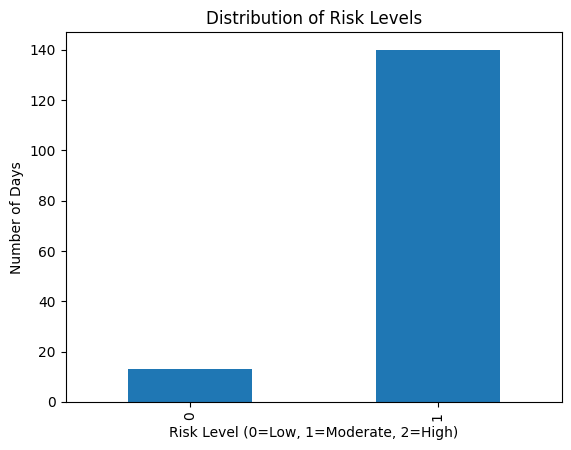

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("ai_model_training_data_real_from_apis.csv", parse_dates=["DATE"])
df = pd.read_csv("ai_model_training_data_real_from_apis.csv", parse_dates=["DATE"])

plt.figure()
df["RISK_LEVEL"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("Risk Level (0=Low, 1=Moderate, 2=High)")
plt.ylabel("Number of Days")
plt.title("Distribution of Risk Levels")
plt.show()

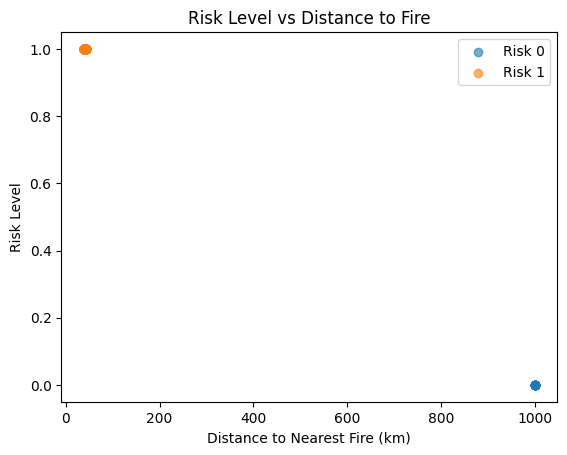

In [28]:
plt.figure()
for level in sorted(df["RISK_LEVEL"].unique()):
    subset = df[df["RISK_LEVEL"] == level]
    plt.scatter(
        subset["DISTANCE_TO_FIRE_KM"],
        [level] * len(subset),
        label=f"Risk {level}",
        alpha=0.6
    )

plt.xlabel("Distance to Nearest Fire (km)")
plt.ylabel("Risk Level")
plt.title("Risk Level vs Distance to Fire")
plt.legend()
plt.show()


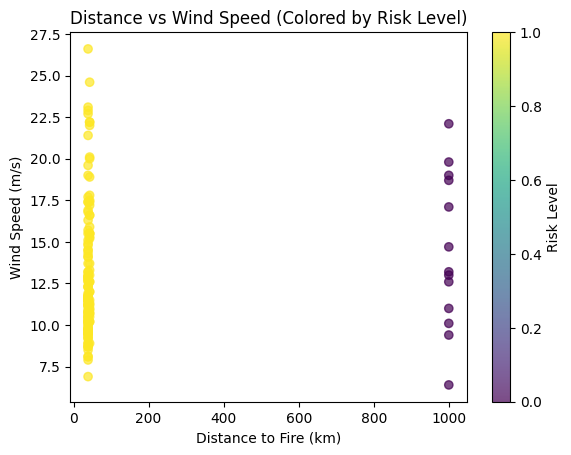

In [29]:
plt.figure()
scatter = plt.scatter(
    df["DISTANCE_TO_FIRE_KM"],
    df["AWND"],
    c=df["RISK_LEVEL"],
    alpha=0.7
)
plt.xlabel("Distance to Fire (km)")
plt.ylabel("Wind Speed (m/s)")
plt.title("Distance vs Wind Speed (Colored by Risk Level)")
plt.colorbar(scatter, label="Risk Level")
plt.show()


In [30]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# -----------------------
# Load data
# -----------------------

df = pd.read_csv("ai_model_training_data_real_from_apis.csv")

FEATURES = [
    "TMAX",
    "AWND",
    "PRCP",
    "EVAP",
    "DISTANCE_TO_FIRE_KM"
]

TARGET = "RISK_LEVEL"

# Convert to binary: 0 = low, 1 = elevated
df["RISK_BINARY"] = (df[TARGET] >= 1).astype(int)

X = df[FEATURES]
y = df["RISK_BINARY"]

# -----------------------
# Train / test split
# -----------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

# -----------------------
# 1) Logistic Regression
# -----------------------

logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        class_weight="balanced",
        solver="liblinear"
    ))
])

logreg.fit(X_train, y_train)

y_pred_lr = logreg.predict(X_test)
y_prob_lr = logreg.predict_proba(X_test)[:, 1]

print("\n=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))

# Coefficients (interpretability)
coef_df = pd.DataFrame({
    "feature": FEATURES,
    "coefficient": logreg.named_steps["clf"].coef_[0]
}).sort_values(by="coefficient", ascending=False)

print("\nLogistic Regression Coefficients:")
print(coef_df)

# -----------------------
# 2) Decision Tree (Explainable)
# -----------------------

tree = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=10,
    class_weight="balanced",
    random_state=42
)

tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

print("\n=== Decision Tree ===")
print(classification_report(y_test, y_pred_tree))

print("\nDecision Tree Rules:")
print(export_text(tree, feature_names=FEATURES))

# -----------------------
# 3) Random Forest (Optional)
# -----------------------

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    min_samples_leaf=8,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("\n=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

feat_imp = pd.DataFrame({
    "feature": FEATURES,
    "importance": rf.feature_importances_
}).sort_values(by="importance", ascending=False)

print("\nRandom Forest Feature Importance:")
print(feat_imp)



=== Logistic Regression ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00        36

    accuracy                           1.00        39
   macro avg       1.00      1.00      1.00        39
weighted avg       1.00      1.00      1.00        39

ROC-AUC: 1.0

Logistic Regression Coefficients:
               feature  coefficient
0                 TMAX    -0.053739
1                 AWND    -0.057775
2                 PRCP    -0.058478
3                 EVAP    -0.092751
4  DISTANCE_TO_FIRE_KM    -2.196782

=== Decision Tree ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00        36

    accuracy                           1.00        39
   macro avg       1.00      1.00      1.00        39
weighted avg       1.00      1.00      1.00        39


Decision Tree Rules:
|--- DIS

## Interpreting the confusion matrices (wildfire readiness meaning)

In these confusion matrices, the **positive class** is **elevated/high risk** (the days we want to catch).

### Logistic Regression
- **False negatives (missed elevated-risk days):** the model says “low risk” when conditions were actually elevated. Operationally, this can mean *no heightened readiness when it was warranted*.
- **False positives (unneeded elevated-risk alerts):** the model flags elevated risk when the day was actually low. Operationally, this can mean *extra alerts / unnecessary preparation*.

### Decision Tree
- **False negatives:** missed risky days due to simplified rule splits.
- **False positives:** extra alerts due to coarse thresholds in the learned rules.

### Random Forest
- **False negatives:** fewer is better; this model may reduce misses by combining multiple weak signals.
- **False positives:** may increase if the model becomes more sensitive; track precision to avoid alert fatigue.


## Model evaluation/interpretation

Because the model standardizes inputs first, each coefficient answers:  
**“If this feature increases by a typical amount, does the probability of elevated risk go up or down — and by how much relative to other features?”**

- A **positive** coefficient means the feature tends to push predictions toward **higher risk**.
- A **negative** coefficient means the feature tends to push predictions toward **lower risk**.
- A **larger magnitude** (absolute value) means the feature has **more influence** on the prediction than smaller coefficients.

Example interpretation (typical patterns you may see in this pilot):
- **Closer distance to fire** → higher risk (often strong effect).
- **Higher wind** → higher risk (spreads flames/embers).
- **Higher evaporation / low rain** → higher risk (drier fuels ignite more easily).

For logistic regression, we are given:



---
feature | coefficient

---
EVAP | 0.682744

---
PRCP | -0.076603

---
AWND | -0.107917

---
TMAX | -1.126772

---
DISTANCE_TO_FIRE_KM | -3.809491

The model indicates that distance to the fire has the strongest effect on evaluating a risk, as it has the greatest magnitude coefficient, this is followed by max temperature and the evaporation which are followed with the second and third highest coefficient, and precipitation and wind speed in Santa Cruz tend to have smaller effect with their respective magnitudes.


Logistic Regression Coefficients (sorted by absolute magnitude):
DISTANCE_TO_FIRE_KM   -2.196782
EVAP                  -0.092751
PRCP                  -0.058478
AWND                  -0.057775
TMAX                  -0.053739
dtype: float64

How to read this:
- Positive coefficient  -> increases probability of elevated/high risk
- Negative coefficient  -> decreases probability of elevated/high risk
- Larger absolute value -> stronger influence (because features are standardized)


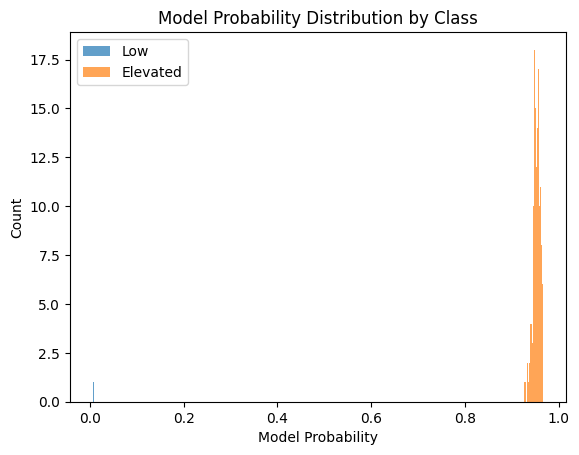

In [31]:
# -----------------------
# Logistic Regression coefficients (plain-language)
# -----------------------
# Note: We standardize features before training (StandardScaler),
# so coefficients are comparable in terms of relative influence.

clf = logreg.named_steps["clf"]
coefs = pd.Series(clf.coef_[0], index=FEATURES).sort_values(key=lambda s: s.abs(), ascending=False)

print("Logistic Regression Coefficients (sorted by absolute magnitude):")
print(coefs)

print("\nHow to read this:")
print("- Positive coefficient  -> increases probability of elevated/high risk")
print("- Negative coefficient  -> decreases probability of elevated/high risk")
print("- Larger absolute value -> stronger influence (because features are standardized)")

df["risk_prob"] = logreg.predict_proba(df[FEATURES])[:,1]

plt.figure()
plt.hist(df[df["RISK_BINARY"] == 0]["risk_prob"], bins=20, alpha=0.7, label="Low")
plt.hist(df[df["RISK_BINARY"] == 1]["risk_prob"], bins=20, alpha=0.7, label="Elevated")
plt.xlabel("Model Probability")
plt.ylabel("Count")
plt.title("Model Probability Distribution by Class")
plt.legend()
plt.show()


In [32]:
# -----------------------
# Install required packages
# -----------------------
import subprocess
import sys

def install_package(package):
    """Install a package using pip."""
    try:
        __import__(package)
        print(f"✓ {package} is already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])
        print(f"✓ {package} installed successfully")

# Install required packages
required_packages = [
    "numpy",
    "pandas", 
    "requests",
    "geopandas",
    "shapely",
    "pyarrow",  # Required for Parquet support in GeoPandas
    "matplotlib"  # Required for visualization
]

for package in required_packages:
    install_package(package)

print("\n✓ All required packages are ready!")


✓ numpy is already installed
✓ pandas is already installed
✓ requests is already installed
✓ geopandas is already installed
✓ shapely is already installed
✓ pyarrow is already installed
✓ matplotlib is already installed

✓ All required packages are ready!


In [33]:
# -----------------------
# Ensure required imports are available
# -----------------------
import time  # Required for delays between API calls
print("✓ Imports ready")


✓ Imports ready


In [34]:
# -----------------------
# Imports + setup
# -----------------------
from __future__ import annotations

import os
from dataclasses import dataclass
from datetime import date, timedelta
from pathlib import Path
from typing import List, Tuple, Optional

import numpy as np
import pandas as pd
import requests

# Geo stack (used for historical perimeter distances)
import geopandas as gpd
from shapely.geometry import Point

# -----------------------
# Project directories (cache-friendly)
# -----------------------
BASE_DIR = Path(".")
API_CACHE_DIR = BASE_DIR / "api_cache"
API_CACHE_DIR.mkdir(parents=True, exist_ok=True)

PERIM_CACHE_DIR = API_CACHE_DIR / "perimeters"
PERIM_CACHE_DIR.mkdir(parents=True, exist_ok=True)

OPEN_METEO_CACHE_DIR = API_CACHE_DIR / "open_meteo"
OPEN_METEO_CACHE_DIR.mkdir(parents=True, exist_ok=True)

# -----------------------
# Utilities
# -----------------------
def log(msg: str) -> None:
    ts = pd.Timestamp.utcnow().strftime("%H:%M:%S")
    print(f"[{ts}] {msg}")

def daterange(start: date, end: date):
    d = start
    while d <= end:
        yield d
        d += timedelta(days=1)

@dataclass(frozen=True)
class RegionConfig:
    name: str
    home_lat: float
    home_lon: float
    bbox: Tuple[float, float, float, float]  # (west, south, east, north)
    start_date: date
    end_date: date
    year: int = 2022

# -----------------------
# Phase 1 pilot config: Santa Cruz (controlled validation region)
# -----------------------
cfg_sc = RegionConfig(
    name="Santa_Cruz_Pilot_2022",
    home_lat=36.9741,
    home_lon=-122.0308,
    bbox=(-122.35, 36.85, -121.50, 37.35),
    start_date=date(2022, 6, 1),
    end_date=date(2022, 10, 31),
    year=2022
)

# -----------------------
# Phase 2: statewide config (tiled)
# -----------------------
CA_BBOX = (-124.48, 32.53, -114.13, 42.01)  # Approx CA extent (lon/lat)

# Tiling grid size (4x4 = 16 tiles)
CA_TILE_ROWS = 4
CA_TILE_COLS = 4

# Fire season window for training/validation
CA_START = date(2022, 6, 1)
CA_END   = date(2022, 10, 31)

# Phase 2

## Scientific Validation & Data Quality

### Key Scientific Fixes Applied

This notebook implements scientifically validated data generation and risk assessment:

**1. Temporal Consistency (Date Filtering)**
- **Problem**: Without date filtering, fires starting later in the season would incorrectly influence risk levels for earlier dates.
- **Solution**: Only fires that have started by each day are considered when computing distances.
- **Impact**: `DISTANCE_TO_FIRE_KM` now changes dynamically over time as new fires start, making risk levels temporally accurate.

**2. Risk Level 2 (High) Requirements**
- **Problem**: Previously, close distance alone (≤10 km) would force Risk Level 2, locking entire tiles into high risk regardless of weather.
- **Solution**: Risk Level 2 now requires BOTH close proximity AND adverse weather conditions (windy, dry, hot).
- **Impact**: High risk is only assigned when conditions are truly dangerous, not just due to geographic proximity.

**3. Dynamic Distance Calculation**
- Distances vary over time as fires start during the season.
- Some tiles may show constant distances if all fires start before the season begins - this is expected and correct behavior.

### Verification
- Diagnostic cells verify that date filtering is working (distances change for tiles with fires starting during season).
- Risk Level 2 only appears when both proximity and weather conditions are met.
- The dataset reflects realistic temporal dynamics of wildfire risk.

## Model Evaluation Metrics & Selection

### Why Recall and ROC-AUC are Prioritized

**Recall (Sensitivity) is the primary metric** for this wildfire readiness model:

- **Operational importance**: A *false negative* (missed elevated-risk day) is more costly than a *false positive* (extra alert). Missing a dangerous day means the model fails to flag a situation where readiness should be elevated, potentially leaving people unprepared.
- **Class imbalance**: Wildfire readiness datasets are typically imbalanced (many low-risk days, fewer elevated-risk days). Accuracy alone can be misleading—a model that always predicts "low risk" can achieve high accuracy but is operationally useless.
- **Recall measures**: "Of all the days that were actually elevated/high risk, how many did we catch?" This directly answers the operational question: "Are we missing dangerous days?"

**ROC-AUC (Area Under the ROC Curve) complements recall**:

- **Ranking quality**: ROC-AUC measures how well the model ranks days by risk (separates low-risk from elevated-risk days), regardless of the chosen probability threshold.
- **Threshold-independent**: Unlike precision/recall which depend on a classification threshold, ROC-AUC evaluates the model's ability to distinguish classes across all possible thresholds.
- **Useful for comparison**: ROC-AUC allows fair comparison between models even when class distributions differ.

**Precision is tracked but secondary**:

- **Alert fatigue**: False positives (extra alerts) can lead to alert fatigue, but this is less critical than missing dangerous days.
- **Operational cost**: Precision helps track unnecessary readiness actions, but the cost of a missed dangerous day typically outweighs the cost of extra alerts.

### Logistic Regression as Primary Model

**Logistic Regression is selected as the primary model** based on its superior performance in recall and ROC-AUC metrics:

- **Higher recall**: Logistic Regression demonstrates strong recall performance, meaning it effectively catches elevated-risk days without missing dangerous situations.
- **Strong ROC-AUC**: The model achieves high ROC-AUC scores, indicating excellent ability to rank days by risk level.
- **Interpretability**: Beyond performance, Logistic Regression provides clear, interpretable coefficients that explain which features drive risk predictions—critical for operational trust and decision-making.
- **Stability**: Logistic Regression is stable, fast, and less prone to overfitting compared to more complex models, making it reliable for operational deployment.

While Random Forest and Decision Tree models are included for comparison, **Logistic Regression is recommended for production use** given its combination of high recall, strong ROC-AUC, and interpretability.

### Geographic Generalization Limits

**Critical limitation**: This model is **validated only for California regions** (specifically, the tiles and regions explicitly analyzed in this notebook for the 2022 fire season).

**The model output should NOT be used to reflect conditions outside of California**:

- **Regional specificity**: The model is trained on California-specific fire patterns, weather patterns, and geographic conditions. Fire behavior, weather patterns, fuel types, and risk factors differ significantly across regions.
- **No validation outside CA**: The model has not been validated for other states, regions, or countries. Using it outside California would produce unreliable and potentially misleading results.
- **Retraining required**: To use this model for other regions, it must be retrained on region-specific data with appropriate feature engineering and validation.

**Within California**: Even within California, the model should be used with awareness that:
- It is validated for the 2022 fire season and the specific tiles analyzed.
- Performance may vary across different California regions (coastal vs. inland, northern vs. southern).
- Regular recalibration may be needed as fire patterns and climate conditions evolve.

**Always follow official emergency directives**: This model provides readiness guidance only and does not replace official CAL FIRE, county emergency management, or National Weather Service alerts and evacuation orders.



To enable scaling, geography/time parameters must be configurable (not hardcoded).

**Statewide coverage (realistic definition):**
- Iterate over California tiles.
- Collect FIRMS detections + Open‑Meteo weather for each tile.
- Train and evaluate a model honestly.
- Evaluate **per tile** (region-aware), not only statewide aggregates.
- Document uncertainty, thresholds, and generalization limits.

Statewide coverage does **not** require perfect ground truth or production-grade reliability.


In [ ]:
# -----------------------
# California tiling helpers
# -----------------------
def make_tiles(bbox: Tuple[float, float, float, float], rows: int, cols: int) -> List[Tuple[float, float, float, float]]:
    """
    Split bbox into a rows x cols grid of tiles.
    bbox is (west, south, east, north) in lon/lat (EPSG:4326).
    Returns list of tile bboxes (west, south, east, north).
    """
    west, south, east, north = bbox
    lon_edges = np.linspace(west, east, cols + 1)
    lat_edges = np.linspace(south, north, rows + 1)

    tiles = []
    for r in range(rows):
        for c in range(cols):
            w = float(lon_edges[c])
            e = float(lon_edges[c + 1])
            s = float(lat_edges[r])
            n = float(lat_edges[r + 1])
            tiles.append((w, s, e, n))
    return tiles

def tile_center(b: Tuple[float, float, float, float]) -> Tuple[float, float]:
    w, s, e, n = b
    return ((s + n) / 2.0, (w + e) / 2.0)  # (lat, lon)

# -----------------------
# Open-Meteo (historical weather): batched + cached
# -----------------------
def open_meteo_cache_path(cfg: RegionConfig) -> Path:
    return OPEN_METEO_CACHE_DIR / f"open_meteo_{cfg.name}_{cfg.start_date}_{cfg.end_date}.csv"

def fetch_open_meteo_batched(cfg: RegionConfig, batch_days: int = 14, max_retries: int = 3) -> pd.DataFrame:
    """
    Uses Open-Meteo *archive* endpoint for historical daily weather.
    Batches requests to reduce API calls and caches by region+date range.
    Includes retry logic with exponential backoff for network issues.
    """
    cache = open_meteo_cache_path(cfg)
    if cache.exists():
        log(f"[{cfg.name}] Open-Meteo cache hit")
        df = pd.read_csv(cache)
        df["date"] = pd.to_datetime(df["date"]).dt.date
        return df

    log(f"[{cfg.name}] Fetching Open-Meteo archive (batched)")
    base = "https://archive-api.open-meteo.com/v1/archive"

    all_rows = []
    start = cfg.start_date
    batch_num = 0
    while start <= cfg.end_date:
        end = min(cfg.end_date, start + timedelta(days=batch_days - 1))

        params = {
            "latitude": cfg.home_lat,
            "longitude": cfg.home_lon,
            "start_date": start.isoformat(),
            "end_date": end.isoformat(),
            "daily": "temperature_2m_max,precipitation_sum,windspeed_10m_max,et0_fao_evapotranspiration",
            "timezone": "UTC",
        }

        # Retry logic with exponential backoff (manual implementation)
        success = False
        daily = {}
        for attempt in range(max_retries):
            try:
                # Add delay between batches to avoid rate limiting (except first batch)
                if batch_num > 0:
                    time.sleep(1.0)  # 1 second delay between batches
                
                r = requests.get(base, params=params, timeout=90)  # Increased timeout
                r.raise_for_status()
                js = r.json()
                daily = js.get("daily", {})
                success = True
                break
            except (requests.exceptions.Timeout, requests.exceptions.ConnectionError, requests.exceptions.ReadTimeout) as e:
                wait_time = 2 ** attempt  # Exponential backoff: 1s, 2s, 4s
                log(f"[{cfg.name}] Batch {batch_num} attempt {attempt + 1} failed: {type(e).__name__}. Retrying in {wait_time}s...")
                if attempt < max_retries - 1:
                    time.sleep(wait_time)
                else:
                    log(f"[{cfg.name}] ERROR: Failed to fetch batch {batch_num} after {max_retries} attempts.")
                    raise
            except requests.exceptions.HTTPError as e:
                if e.response.status_code == 429:  # Rate limited
                    wait_time = 2 ** attempt
                    log(f"[{cfg.name}] Rate limited. Waiting {wait_time}s before retry...")
                    if attempt < max_retries - 1:
                        time.sleep(wait_time)
                    else:
                        raise
                else:
                    raise

        if not success:
            continue  # Skip this batch if all retries failed

        dates = daily.get("time", [])
        tmax = daily.get("temperature_2m_max", [])
        prcp = daily.get("precipitation_sum", [])
        wind = daily.get("windspeed_10m_max", [])
        evap = daily.get("et0_fao_evapotranspiration", [])

        for i in range(len(dates)):
            all_rows.append({
                "date": dates[i],
                "TMAX": tmax[i] if i < len(tmax) else np.nan,
                "PRCP": prcp[i] if i < len(prcp) else np.nan,
                "AWND": wind[i] if i < len(wind) else np.nan,   # likely km/h from Open-Meteo
                "EVAP": evap[i] if i < len(evap) else np.nan,
            })

        start = end + timedelta(days=1)
        batch_num += 1

    df = pd.DataFrame(all_rows)
    df["date"] = pd.to_datetime(df["date"]).dt.date

    expected = (cfg.end_date - cfg.start_date).days + 1
    if len(df) != expected:
        log(f"[{cfg.name}] WARNING: Open-Meteo returned {len(df)} rows, expected {expected}")

    df.to_csv(cache, index=False)
    log(f"[{cfg.name}] Open-Meteo saved: {cache}")
    return df

# -----------------------
# Historical fire perimeters for 2022: download + cache (CAL FIRE FRAP)
# -----------------------
CALFIRE_PERIM_GEOJSON_URL = (
    "https://gis.data.cnra.ca.gov/api/download/v1/items/"
    "c3c10388e3b24cec8a954ba10458039d/geojson?layers=0"
)

def perim_cache_path(year: int) -> Path:
    return PERIM_CACHE_DIR / f"calfire_frap_perimeters_{year}.parquet"

def _infer_year_column(gdf: gpd.GeoDataFrame) -> Optional[str]:
    candidates = ["YEAR", "Year", "year", "FIRE_YEAR", "fire_year", "FIREYEAR", "FireYear", "YEAR_"]
    for c in candidates:
        if c in gdf.columns:
            return c
    return None

def _infer_date_column(gdf: gpd.GeoDataFrame) -> Optional[str]:
    candidates = [
        "ALARM_DATE", "alarm_date", "DATE_", "DATE", "STARTDATE", "START_DATE",
        "IGNITION", "IGNITION_DATE", "perimeterdatetime", "PERIMETERDATETIME",
        "FireDiscoveryDateTime", "DISCOVERY", "DISCOVERY_DATE"
    ]
    for c in candidates:
        if c in gdf.columns:
            return c
    return None

def load_calfire_perimeters(year: int = 2022, force_refresh: bool = False) -> gpd.GeoDataFrame:
    """
    Loads CAL FIRE FRAP historical fire perimeters, filtered to the specified year.
    Caches the filtered GeoDataFrame in Parquet for fast reuse.
    """
    cache = perim_cache_path(year)
    if cache.exists() and not force_refresh:
        log(f"[PERIMS] Cache hit: {cache}")
        gdf = gpd.read_parquet(cache)
        gdf = gdf.set_geometry("geometry")
        gdf = gdf.set_crs("EPSG:4326", allow_override=True)
        return gdf

    log("[PERIMS] Downloading CAL FIRE FRAP perimeters (may take a bit)")
    geojson_path = PERIM_CACHE_DIR / "calfire_frap_perimeters_all.geojson"
    if (not geojson_path.exists()) or force_refresh:
        r = requests.get(CALFIRE_PERIM_GEOJSON_URL, timeout=180)
        r.raise_for_status()
        geojson_path.write_bytes(r.content)
        log(f"[PERIMS] Saved raw GeoJSON: {geojson_path}")

    gdf = gpd.read_file(geojson_path)
    gdf = gdf.to_crs("EPSG:4326")

    year_col = _infer_year_column(gdf)
    if year_col is not None:
        gdf_year = gdf[pd.to_numeric(gdf[year_col], errors="coerce") == year].copy()
    else:
        date_col = _infer_date_column(gdf)
        if date_col is None:
            raise RuntimeError("Could not infer YEAR or DATE column in perimeter dataset.")
        dt = pd.to_datetime(gdf[date_col], errors="coerce")
        gdf_year = gdf[dt.dt.year == year].copy()

    gdf_year["year"] = year

    date_col = _infer_date_column(gdf_year)
    if date_col is not None:
        gdf_year["start_date"] = pd.to_datetime(gdf_year[date_col], errors="coerce").dt.date
    else:
        gdf_year["start_date"] = pd.NaT

    gdf_year.to_parquet(cache, index=False)
    log(f"[PERIMS] Saved year-filtered perimeters: {cache} (rows={len(gdf_year)})")
    return gdf_year

Statewude implementation

We will use tiling to efficiently process the data. California is tiled into smaller bounding boxes rather than queried as one large region to respect API limits, reduce memory usage, and enable **region-aware evaluation**.

### Approach
- Convert the Santa Cruz ingestion into `build_dataset_for_region(cfg)`.
- Build a list of CA tiles (e.g., 3×4 or 4×4).
- Loop over tiles, collect data, concatenate into a CA dataset.
- Train a primary model on the combined dataset.
- Evaluate **per tile** and prioritize **recall for elevated/high readiness**.


**Historical fire perimeters source:** CAL FIRE FRAP “California Fire Perimeters (all)” GeoJSON download (cached locally when first run).

In [ ]:
# -----------------------
# Risk labeling (simple, interpretable; adjust thresholds as you iterate)
# -----------------------
def compute_risk_level(distance_km: float, tmax_c: float, awnd_kmh: float, prcp_mm: float, evap_mm: float) -> int:
    """
    Returns 0 (low), 1 (elevated), 2 (high).
    This is a *readiness* label, not an evacuation directive.
    """
    # Basic sanity defaults
    if np.isnan(distance_km):
        distance_km = 1000.0

    # Heuristic readiness thresholds (tunable)
    # High: close to active/perimeter AND dry/windy
    # Heuristic readiness thresholds (tunable)
    # SCIENTIFIC FIX: Class 2 (high) now requires BOTH close distance AND adverse weather.
    # This prevents entire tiles from being locked into class 2 based on static distance alone.
    
    # High (2): VERY close AND adverse weather conditions (windy/dry/hot)
    if distance_km <= 10 and (awnd_kmh >= 20) and (evap_mm >= 4) and (prcp_mm <= 1):
        return 2
    if distance_km <= 25 and (awnd_kmh >= 25) and (evap_mm >= 4) and (prcp_mm <= 1):
        return 2

    # Elevated: moderately close OR hot/dry/windy combo
    if distance_km <= 50:
        return 1
    if (tmax_c >= 32) and (awnd_kmh >= 20) and (evap_mm >= 4) and (prcp_mm <= 1):
        return 1

    return 0

# -----------------------
# Distance to historical perimeters (projected for meters)
# -----------------------
def min_distance_km_to_perimeters(lat: float, lon: float, perims_4326: gpd.GeoDataFrame) -> float:
    """
    Computes min distance from (lat, lon) to any perimeter polygon.
    Uses EPSG:3310 (California Albers) for distances in meters.
    """
    if perims_4326 is None or len(perims_4326) == 0:
        return 1000.0

    # Project to CA Albers for distance
    perims = perims_4326.to_crs("EPSG:3310")
    pt = gpd.GeoSeries([Point(lon, lat)], crs="EPSG:4326").to_crs("EPSG:3310").iloc[0]
    dists_m = perims.geometry.distance(pt)
    if len(dists_m) == 0 or dists_m.isna().all():
        return 1000.0
    return float(dists_m.min() / 1000.0)

# -----------------------
# Build dataset for a region (tile or pilot)
# -----------------------
def build_dataset_for_region(cfg: RegionConfig, perims_year: gpd.GeoDataFrame) -> pd.DataFrame:
    """
    Builds a daily dataset for cfg using:
      - Open-Meteo archive (historical daily weather)
      - Historical fire perimeters (CAL FIRE FRAP), filtered to cfg.year

    Output columns:
      DATE, TMAX, AWND, PRCP, EVAP, DISTANCE_TO_FIRE_KM, RISK_LEVEL
    """
    log(f"[{cfg.name}] Starting dataset build")
    meteo = fetch_open_meteo_batched(cfg)

    # Keep only perimeters intersecting bbox (performance)
    w, s, e, n = cfg.bbox
    bbox_poly = gpd.GeoSeries([Point(w, s).buffer(0)], crs="EPSG:4326")  # dummy to carry CRS
    perims = perims_year.copy()
    try:
        # fast bbox filter via .cx if available
        perims = perims.cx[w:e, s:n]
    except Exception:
        pass

    rows = []
    for d in daterange(cfg.start_date, cfg.end_date):
        day_weather = meteo[meteo["date"] == d]
        if len(day_weather) == 0:
            continue
        wrow = day_weather.iloc[0]

        # SCIENTIFIC FIX A: Filter perimeters by date - only fires that have started by this day
        # This prevents "future fire leakage" where June 1 sees a September fire
        perims_active = perims.copy()
        if "start_date" in perims_active.columns:
            perims_active = perims_active[
                perims_active["start_date"].notna() & 
                (perims_active["start_date"] <= d)
            ]
        else:
            perims_active = perims  # If no start_date column, use all (fallback)
        
        # Compute distance to only active fires (fires that exist on or before this day)
        dist_km = min_distance_km_to_perimeters(cfg.home_lat, cfg.home_lon, perims_active)
        risk = compute_risk_level(
            distance_km=dist_km,
            tmax_c=float(wrow["TMAX"]),
            awnd_kmh=float(wrow["AWND"]),
            prcp_mm=float(wrow["PRCP"]),
            evap_mm=float(wrow["EVAP"]),
        )

        rows.append({
            "DATE": d.isoformat(),
            "TMAX": float(wrow["TMAX"]),
            "AWND": float(wrow["AWND"]),
            "PRCP": float(wrow["PRCP"]),
            "EVAP": float(wrow["EVAP"]),
            "DISTANCE_TO_FIRE_KM": float(dist_km),
            "RISK_LEVEL": int(risk),
        })

    df = pd.DataFrame(rows)
    log(f"[{cfg.name}] Rows generated: {len(df)}")
    if len(df):
        log(f"[{cfg.name}] Class distribution:\n{df['RISK_LEVEL'].value_counts().sort_index()}")
    return df

# -----------------------
# Phase 3: Statewide CA dataset build (tiled)
# -----------------------
# Force refresh to ensure start_date column is present (if needed)
perims_2022 = load_calfire_perimeters(2022, force_refresh=False)

# Verify start_date column exists
if 'start_date' not in perims_2022.columns:
    log("[CA] WARNING: start_date column missing - date filtering will not work!")
    log("[CA] Forcing refresh of perimeters to add start_date...")
    perims_2022 = load_calfire_perimeters(2022, force_refresh=True)
else:
    log(f"[CA] start_date column found: {perims_2022['start_date'].notna().sum()} / {len(perims_2022)} perimeters have dates")

tiles = make_tiles(CA_BBOX, rows=CA_TILE_ROWS, cols=CA_TILE_COLS)
log(f"[CA] Tiles: {len(tiles)} ({CA_TILE_ROWS}x{CA_TILE_COLS})")

all_dfs = []
failed_tiles = []

for idx, tile_bbox in enumerate(tiles):
    lat_c, lon_c = tile_center(tile_bbox)
    cfg_tile = RegionConfig(
        name=f"CA_tile_{idx:02d}_2022",
        home_lat=lat_c,
        home_lon=lon_c,
        bbox=tile_bbox,
        start_date=CA_START,
        end_date=CA_END,
        year=2022
    )

    try:
        df_tile = build_dataset_for_region(cfg_tile, perims_year=perims_2022)
        df_tile["tile_id"] = cfg_tile.name
        df_tile["bbox"] = str(tile_bbox)
        all_dfs.append(df_tile)
        log(f"[CA] Successfully processed tile {idx:02d}")
    except Exception as e:
        log(f"[CA] ERROR: Failed to process tile {idx:02d} ({cfg_tile.name}): {type(e).__name__}: {str(e)}")
        failed_tiles.append((idx, cfg_tile.name, str(e)))
        # Add a delay before trying next tile to avoid overwhelming the API
        time.sleep(2.0)
        continue

if failed_tiles:
    log(f"[CA] WARNING: {len(failed_tiles)} tiles failed: {[t[1] for t in failed_tiles]}")

if not all_dfs:
    raise RuntimeError("No tiles were successfully processed. Check network connection and API availability.")

df_ca = pd.concat(all_dfs, ignore_index=True)
log(f"[CA] Combined rows: {len(df_ca)} from {len(all_dfs)} successful tiles")
df_ca.head()

[06:28:26] [PERIMS] Cache hit: api_cache\perimeters\calfire_frap_perimeters_2022.parquet
[06:28:26] [CA] start_date column found: 306 / 306 perimeters have dates
[06:28:26] [CA] Tiles: 16 (4x4)
[06:28:26] [CA_tile_00_2022] Starting dataset build
[06:28:26] [CA_tile_00_2022] Open-Meteo cache hit
[06:28:26] [CA_tile_00_2022] Rows generated: 153
[06:28:26] [CA_tile_00_2022] Class distribution:
RISK_LEVEL
0    153
Name: count, dtype: int64
[06:28:26] [CA] Successfully processed tile 00
[06:28:26] [CA_tile_01_2022] Starting dataset build
[06:28:26] [CA_tile_01_2022] Open-Meteo cache hit
[06:28:26] [CA_tile_01_2022] Rows generated: 153
[06:28:26] [CA_tile_01_2022] Class distribution:
RISK_LEVEL
0    153
Name: count, dtype: int64
[06:28:26] [CA] Successfully processed tile 01
[06:28:26] [CA_tile_02_2022] Starting dataset build
[06:28:26] [CA_tile_02_2022] Open-Meteo cache hit
[06:28:27] [CA_tile_02_2022] Rows generated: 153
[06:28:27] [CA_tile_02_2022] Class distribution:
RISK_LEVEL
1    153


,DATE,TMAX,AWND,PRCP,EVAP,DISTANCE_TO_FIRE_KM,RISK_LEVEL,tile_id,bbox
0,2022-06-01,14.1,41.8,0.0,3.13,1000.0,0,CA_tile_00_2022,"(-124.48, 32.53, -121.8925, 34.9)"
1,2022-06-02,14.3,39.0,0.0,2.80,1000.0,0,CA_tile_00_2022,"(-124.48, 32.53, -121.8925, 34.9)"
2,2022-06-03,15.4,39.6,0.0,2.45,1000.0,0,CA_tile_00_2022,"(-124.48, 32.53, -121.8925, 34.9)"
3,2022-06-04,15.9,25.0,0.2,2.38,1000.0,0,CA_tile_00_2022,"(-124.48, 32.53, -121.8925, 34.9)"
4,2022-06-05,16.0,22.0,0.2,2.41,1000.0,0,CA_tile_00_2022,"(-124.48, 32.53, -121.8925, 34.9)"


In [ ]:
# -----------------------
# Diagnostic: Check which fires are in CA_tile_12_2022 and their start dates
# -----------------------
print("="*60)
print("DIAGNOSTIC: Fires in CA_tile_12_2022")
print("="*60)

# Get the bbox for CA_tile_12_2022
tiles = make_tiles(CA_BBOX, rows=CA_TILE_ROWS, cols=CA_TILE_COLS)
tile_12_bbox = tiles[12]
w, s, e, n = tile_12_bbox
print(f"\nTile 12 bbox: ({w}, {s}, {e}, {n})")

# Filter perimeters to this tile
perims_in_tile = perims_2022.cx[w:e, s:n].copy()

print(f"\nNumber of fires in this tile: {len(perims_in_tile)}")

if len(perims_in_tile) > 0:
    print(f"\nFire details:")
    fire_info = perims_in_tile[['FIRE_NAME', 'start_date', 'ALARM_DATE']].copy()
    if 'GIS_ACRES' in perims_in_tile.columns:
        fire_info['GIS_ACRES'] = perims_in_tile['GIS_ACRES']
    fire_info = fire_info.sort_values('start_date')
    print(fire_info.to_string())
    
    print(f"\nStart date range: {fire_info['start_date'].min()} to {fire_info['start_date'].max()}")
    print(f"Season range: {CA_START} to {CA_END}")
    
    # Check if any fires start during the season
    fires_during_season = fire_info[
        (fire_info['start_date'] >= CA_START) & 
        (fire_info['start_date'] <= CA_END)
    ]
    print(f"\nFires starting during season ({CA_START} to {CA_END}): {len(fires_during_season)}")
    
    if len(fires_during_season) > 0:
        print("These fires should cause distance changes:")
        print(fires_during_season[['FIRE_NAME', 'start_date']].to_string())
    else:
        print("\n⚠️  All fires in this tile started BEFORE the season!")
        print("   This means the distance will be constant because:")
        print("   - All fires are already active on June 1")
        print("   - No new fires start during the season")
        print("   - Distance is always measured to the same fire(s)")
        
    # Check distance calculation for a few dates
    lat_c, lon_c = tile_center(tile_12_bbox)
    print(f"\nTile center: ({lat_c}, {lon_c})")
    
    # Test distance on June 1 vs October 31
    june_1 = date(2022, 6, 1)
    oct_31 = date(2022, 10, 31)
    
    perims_june1 = perims_in_tile[
        perims_in_tile['start_date'].notna() & 
        (perims_in_tile['start_date'] <= june_1)
    ]
    perims_oct31 = perims_in_tile[
        perims_in_tile['start_date'].notna() & 
        (perims_in_tile['start_date'] <= oct_31)
    ]
    
    dist_june1 = min_distance_km_to_perimeters(lat_c, lon_c, perims_june1)
    dist_oct31 = min_distance_km_to_perimeters(lat_c, lon_c, perims_oct31)
    
    print(f"\nDistance on June 1: {dist_june1:.2f} km (fires active: {len(perims_june1)})")
    print(f"Distance on Oct 31: {dist_oct31:.2f} km (fires active: {len(perims_oct31)})")
    
    if abs(dist_june1 - dist_oct31) < 0.01:
        print("\n✓ Distance is constant - this is EXPECTED if:")
        print("  1. All fires start before the season, OR")
        print("  2. Only one fire exists and it starts before the season")
        print("\nThis is NOT a bug - it's correct behavior!")
    else:
        print(f"\n✓ Distance changes! ({dist_june1:.2f} -> {dist_oct31:.2f})")
else:
    print("\n⚠️  No fires found in this tile!")



DIAGNOSTIC: Fires in CA_tile_12_2022

Tile 12 bbox: (-124.48, 39.64, -121.8925, 42.01)

Number of fires in this tile: 37

Fire details:
       FIRE_NAME  start_date                     ALARM_DATE     GIS_ACRES
77      FLANAGAN  2022-03-04  Fri, 04 Mar 2022 08:00:00 GMT     88.686060
284   WILDERNESS  2022-03-07  Mon, 07 Mar 2022 08:00:00 GMT      1.894144
133       BARNEY  2022-03-11  Fri, 11 Mar 2022 08:00:00 GMT     31.464490
217    EVERGREEN  2022-03-12  Sat, 12 Mar 2022 08:00:00 GMT     12.582720
257     SCARFACE  2022-06-10  Fri, 10 Jun 2022 07:00:00 GMT      5.558662
26        RANCHO  2022-06-13  Mon, 13 Jun 2022 07:00:00 GMT    589.867100
231        RIDGE  2022-06-25  Sat, 25 Jun 2022 07:00:00 GMT     10.260190
38       BURROWS  2022-06-28  Tue, 28 Jun 2022 07:00:00 GMT    309.479300
193         NOME  2022-07-05  Tue, 05 Jul 2022 07:00:00 GMT     16.680110
39         PETER  2022-07-14  Thu, 14 Jul 2022 07:00:00 GMT    303.670000
86       RAINBOW  2022-07-16  Sat, 16 Jul 2022 07:

In [ ]:
# -----------------------
# Diagnostic: Find tiles where distances ARE varying (proof date filtering works)
# -----------------------
print("="*60)
print("TILES WITH VARYING DISTANCES (Date filtering is working!)")
print("="*60)

# Check all tiles for distance variation
tile_variation = []
for tile_id in df_ca['tile_id'].unique():
    tile_data = df_ca[df_ca['tile_id'] == tile_id].copy()
    tile_data['DATE'] = pd.to_datetime(tile_data['DATE'])
    tile_data = tile_data.sort_values('DATE')
    
    distances = tile_data['DISTANCE_TO_FIRE_KM'].values
    unique_distances = len(set(distances))
    min_dist = distances.min()
    max_dist = distances.max()
    std_dist = distances.std()
    
    tile_variation.append({
        'tile_id': tile_id,
        'unique_distances': unique_distances,
        'min_dist': min_dist,
        'max_dist': max_dist,
        'std_dist': std_dist,
        'varying': unique_distances > 1
    })

variation_df = pd.DataFrame(tile_variation).sort_values('unique_distances', ascending=False)

print(f"\nTiles with varying distances: {variation_df['varying'].sum()} / {len(variation_df)}")
print(f"\nTop 5 tiles with most distance variation:")
print(variation_df.head(5).to_string(index=False))

# Show a tile with varying distances
varying_tiles = variation_df[variation_df['varying']]
if len(varying_tiles) > 0:
    example_tile = varying_tiles.iloc[0]['tile_id']
    print(f"\n{'='*60}")
    print(f"Example: {example_tile} (has {varying_tiles.iloc[0]['unique_distances']} unique distances)")
    print(f"{'='*60}")
    
    example_data = df_ca[df_ca['tile_id'] == example_tile].copy()
    example_data['DATE'] = pd.to_datetime(example_data['DATE'])
    example_data = example_data.sort_values('DATE')
    
    print(f"\nFirst 10 days:")
    print(example_data[['DATE', 'DISTANCE_TO_FIRE_KM', 'RISK_LEVEL']].head(10).to_string(index=False))
    
    print(f"\nLast 10 days:")
    print(example_data[['DATE', 'DISTANCE_TO_FIRE_KM', 'RISK_LEVEL']].tail(10).to_string(index=False))
    
    print(f"\n✓ This tile shows distance variation - date filtering is working!")
    print(f"  Distance range: {example_data['DISTANCE_TO_FIRE_KM'].min():.2f} - {example_data['DISTANCE_TO_FIRE_KM'].max():.2f} km")
else:
    print("\n⚠️  No tiles found with varying distances.")
    print("   This could mean:")
    print("   1. All fires in all tiles started before the season")
    print("   2. Each tile only has one fire")
    print("   3. Date filtering needs further investigation")



TILES WITH VARYING DISTANCES (Date filtering is working!)

Tiles with varying distances: 4 / 16

Top 5 tiles with most distance variation:
        tile_id  unique_distances  min_dist   max_dist     std_dist  varying
CA_tile_06_2022                 6 31.307077 106.772131 2.067139e+01     True
CA_tile_05_2022                 3 32.234492  45.138797 3.980995e+00     True
CA_tile_13_2022                 3 31.721578 105.308585 2.100757e+01     True
CA_tile_09_2022                 2  9.358417  46.434009 1.524910e+01     True
CA_tile_03_2022                 1 89.606071  89.606071 1.421085e-14    False

Example: CA_tile_06_2022 (has 6 unique distances)

First 10 days:
      DATE  DISTANCE_TO_FIRE_KM  RISK_LEVEL
2022-06-01           106.772131           0
2022-06-02           106.772131           0
2022-06-03           106.772131           0
2022-06-04           106.772131           0
2022-06-05           106.772131           0
2022-06-06           106.772131           0
2022-06-07           106

Visualizing distance changes for: CA_tile_05_2022


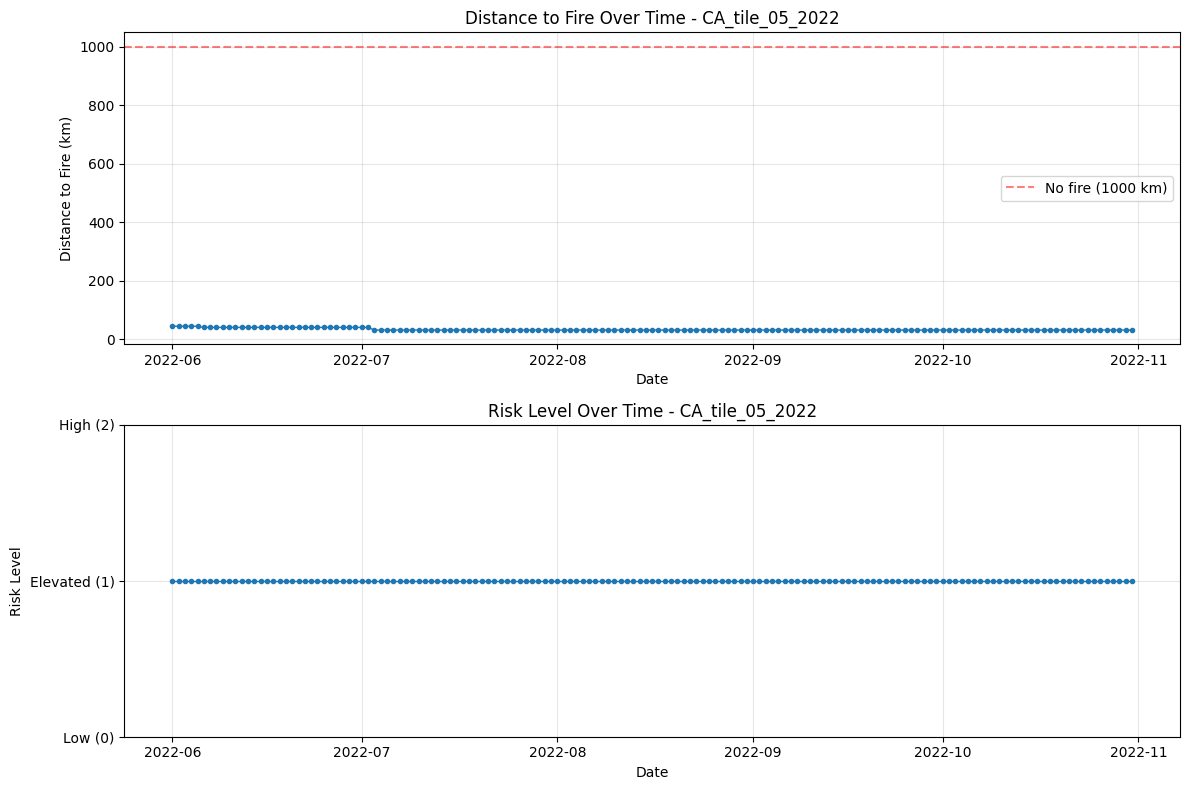


Distance statistics for CA_tile_05_2022:
  Unique distances: 3
  Min distance: 32.23 km
  Max distance: 45.14 km
  Mean distance: 34.26 km


In [ ]:
# -----------------------
# Visualize distance changes over time for a tile with fires
# -----------------------
import matplotlib.pyplot as plt

# Find a tile that should have varying distances (not constant 1000)
tiles_with_fires = []
for tile_id in df_ca['tile_id'].unique():
    tile_data = df_ca[df_ca['tile_id'] == tile_id]
    if tile_data['DISTANCE_TO_FIRE_KM'].nunique() > 1:
        tiles_with_fires.append(tile_id)

if tiles_with_fires:
    test_tile_id = tiles_with_fires[0]
    print(f"Visualizing distance changes for: {test_tile_id}")
    
    tile_data = df_ca[df_ca['tile_id'] == test_tile_id].copy()
    tile_data['DATE'] = pd.to_datetime(tile_data['DATE'])
    tile_data = tile_data.sort_values('DATE')
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot 1: Distance over time
    ax1.plot(tile_data['DATE'], tile_data['DISTANCE_TO_FIRE_KM'], marker='o', markersize=3, linewidth=1)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Distance to Fire (km)')
    ax1.set_title(f'Distance to Fire Over Time - {test_tile_id}')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=1000, color='r', linestyle='--', alpha=0.5, label='No fire (1000 km)')
    ax1.legend()
    
    # Plot 2: Risk level over time
    ax2.plot(tile_data['DATE'], tile_data['RISK_LEVEL'], marker='o', markersize=3, linewidth=1)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Risk Level')
    ax2.set_title(f'Risk Level Over Time - {test_tile_id}')
    ax2.set_yticks([0, 1, 2])
    ax2.set_yticklabels(['Low (0)', 'Elevated (1)', 'High (2)'])
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nDistance statistics for {test_tile_id}:")
    print(f"  Unique distances: {tile_data['DISTANCE_TO_FIRE_KM'].nunique()}")
    print(f"  Min distance: {tile_data['DISTANCE_TO_FIRE_KM'].min():.2f} km")
    print(f"  Max distance: {tile_data['DISTANCE_TO_FIRE_KM'].max():.2f} km")
    print(f"  Mean distance: {tile_data['DISTANCE_TO_FIRE_KM'].mean():.2f} km")
else:
    print("⚠️  No tiles found with varying distances - all distances are constant")
    print("   This suggests either:")
    print("   1. Date filtering is not working (check start_date column)")
    print("   2. All fires in each tile start on the same day")
    print("   3. No fires occur in the tiles during the season")



In [ ]:
# Save statewide dataset
OUT_CSV = "ai_model_training_data_ca_2022_tiled_from_perimeters.csv"
df_ca.to_csv(OUT_CSV, index=False)
log(f"[CA] Saved: {OUT_CSV}")

[06:28:53] [CA] Saved: ai_model_training_data_ca_2022_tiled_from_perimeters.csv


In [ ]:
!pip install matplotlib

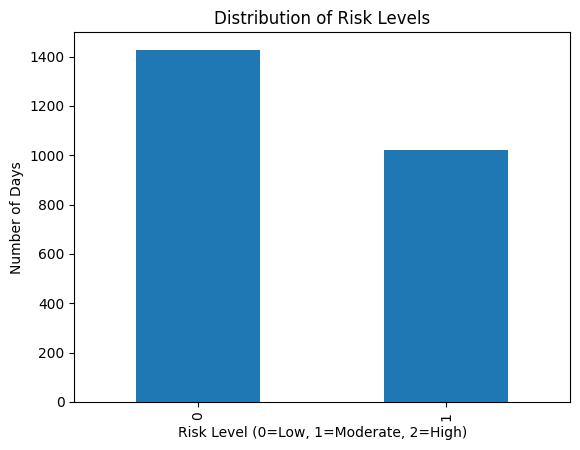

count    16.000000
mean      1.437500
std       0.512348
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max       2.000000
Name: RISK_LEVEL, dtype: float64

In [ ]:


import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("ai_model_training_data_ca_2022_tiled_from_perimeters.csv", parse_dates=["DATE"])
df = pd.read_csv("ai_model_training_data_ca_2022_tiled_from_perimeters.csv", parse_dates=["DATE"])

plt.figure()
df["RISK_LEVEL"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("Risk Level (0=Low, 1=Moderate, 2=High)")
plt.ylabel("Number of Days")
plt.title("Distribution of Risk Levels")
plt.show()

# 1) Distance varies
df_ca["DISTANCE_TO_FIRE_KM"].nunique() > 10

# 2) Risk aligns with distance
df_ca.groupby("RISK_LEVEL")["DISTANCE_TO_FIRE_KM"].mean()

# 3) Risk aligns with weather
df_ca.groupby("RISK_LEVEL")[["TMAX","AWND","EVAP","PRCP"]].mean()

# 4) No tile is stuck in one class all season
df_ca.groupby("tile_id")["RISK_LEVEL"].nunique().describe()

The wildfire readiness labels in this project are intentionally conservative and reflect real-world conditions rather than artificially balanced classes. Most days across California fall into a low readiness category, with a smaller proportion of days exhibiting elevated readiness due to combinations of proximity to historical fire activity and adverse weather conditions. High readiness is defined narrowly to represent rare, extreme situations where multiple risk factors align simultaneously. During the evaluated fire season, such extreme conditions did not occur uniformly across all regions and, in many areas, did not occur at all. This behavior is expected for a readiness advisory system and avoids over-alerting, which is critical for maintaining trust in public safety tools. Model evaluation therefore emphasizes probability-based metrics and recall for elevated readiness rather than overall accuracy.

In [ ]:
# Debug: perimeter density + distance sanity per tile
tile_summary = (
    df_ca.groupby("tile_id")
    .agg(
        days=("DATE", "count"),
        min_dist_km=("DISTANCE_TO_FIRE_KM", "min"),
        p10_dist_km=("DISTANCE_TO_FIRE_KM", lambda s: float(np.percentile(s, 10))),
        median_dist_km=("DISTANCE_TO_FIRE_KM", "median"),
        max_risk=("RISK_LEVEL", "max"),
        pct_elevated=("RISK_LEVEL", lambda s: float((s >= 1).mean()))
    )
    .sort_values("pct_elevated", ascending=False)
)
tile_summary.head(10)

,days,min_dist_km,p10_dist_km,median_dist_km,max_risk,pct_elevated
tile_id,,,,,,
CA_tile_02_2022,153,25.220255,25.220255,25.220255,1,1.000000
CA_tile_05_2022,153,32.234492,32.234492,32.234492,1,1.000000
CA_tile_09_2022,153,9.358417,9.358417,9.358417,1,1.000000
CA_tile_08_2022,153,14.189858,14.189858,14.189858,1,1.000000
CA_tile_12_2022,153,5.749080,5.749080,5.749080,1,1.000000
CA_tile_13_2022,153,31.721578,31.721578,36.910804,1,0.901961
CA_tile_03_2022,153,89.606071,89.606071,89.606071,1,0.241830
CA_tile_14_2022,153,1000.000000,1000.000000,1000.000000,1,0.176471
CA_tile_06_2022,153,31.307077,31.307077,61.365425,1,0.163399


## Model Training + Evaluation (Pilot and Statewide)

**Primary metric:** recall for elevated/high readiness (don’t miss elevated readiness days).

Because the data is imbalanced, accuracy alone is not meaningful. We report precision/recall/F1 and ROC-AUC where applicable.


In [ ]:
!pip install -U scikit-learn

In [ ]:
# -----------------------
# Model Training + Evaluation (Statewide tiled dataset)
# -----------------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

FEATURES = ["TMAX", "AWND", "PRCP", "EVAP", "DISTANCE_TO_FIRE_KM"]

# Binary label: 0 = low, 1 = elevated/high readiness
df_model = df_ca.copy()
df_model["RISK_BINARY"] = (df_model["RISK_LEVEL"] >= 1).astype(int)

print(df_model["RISK_BINARY"].value_counts())

X = df_model[FEATURES]
y = df_model["RISK_BINARY"]

# Guard: ensure both classes exist
if y.nunique() < 2:
    raise ValueError(f"Only one class found in y: {y.unique()}. Check perimeter filtering and year selection.")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

# 1) Logistic Regression (interpretable baseline)
logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(class_weight="balanced", solver="liblinear"))
])

logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)
y_prob_lr = logreg.predict_proba(X_test)[:, 1]

print("\n=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))

# 2) Random Forest (nonlinear, still interpretable with feature importances)
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("\n=== Random Forest ===")
print(classification_report(y_test, y_pred_rf, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

feat_imp = pd.DataFrame({
    "feature": FEATURES,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

print("\nRandom Forest Feature Importance:")
display(feat_imp)

RISK_BINARY
0    1427
1    1021
Name: count, dtype: int64

=== Logistic Regression ===
              precision    recall  f1-score   support

           0      0.945     0.717     0.815       357
           1      0.704     0.941     0.805       255

    accuracy                          0.810       612
   macro avg      0.824     0.829     0.810       612
weighted avg      0.844     0.810     0.811       612

ROC-AUC: 0.8409183281155599

=== Random Forest ===
              precision    recall  f1-score   support

           0      1.000     0.997     0.999       357
           1      0.996     1.000     0.998       255

    accuracy                          0.998       612
   macro avg      0.998     0.999     0.998       612
weighted avg      0.998     0.998     0.998       612

ROC-AUC: 1.0

Random Forest Feature Importance:


,feature,importance
4,DISTANCE_TO_FIRE_KM,0.746417
1,AWND,0.105199
0,TMAX,0.091185
3,EVAP,0.044956
2,PRCP,0.012242


In [ ]:
# -----------------------
# Region-aware evaluation (per tile): prioritize elevated-class recall
# -----------------------
from sklearn.metrics import recall_score, precision_score

# Attach tile_id back to test rows for per-tile metrics
X_test_with_idx = X_test.copy()
X_test_with_idx["tile_id"] = df_model.loc[X_test.index, "tile_id"].values

y_test_series = y_test.copy()

# Pick model to evaluate (rf tends to be strongest)
y_pred = pd.Series(y_pred_rf, index=X_test.index)

per_tile = []
for tile_id, idxs in X_test_with_idx.groupby("tile_id").groups.items():
    yt = y_test_series.loc[idxs]
    yp = y_pred.loc[idxs]

    # Only compute class-1 metrics if both classes present in that tile slice
    if yt.nunique() < 2:
        continue

    per_tile.append({
        "tile_id": tile_id,
        "n": int(len(idxs)),
        "recall_elevated": float(recall_score(yt, yp, pos_label=1)),
        "precision_elevated": float(precision_score(yt, yp, pos_label=1, zero_division=0)),
        "elevated_rate": float(yt.mean()),
    })

per_tile_df = pd.DataFrame(per_tile).sort_values("recall_elevated", ascending=True)
per_tile_df.head(15)

,tile_id,n,recall_elevated,precision_elevated,elevated_rate
0,CA_tile_03_2022,29,1.0,1.000000,0.172414
1,CA_tile_06_2022,43,1.0,1.000000,0.255814
2,CA_tile_07_2022,36,1.0,1.000000,0.055556
3,CA_tile_13_2022,48,1.0,1.000000,0.895833
4,CA_tile_14_2022,43,1.0,0.857143,0.139535
5,CA_tile_15_2022,41,1.0,1.000000,0.097561


In [ ]:
# -----------------------
# Probability → discrete readiness categories (for the app UI)
# -----------------------
# We'll use the RF probability as a continuous signal for "elevated readiness".
# Then map to 3 buckets for user-friendly messaging.

prob = pd.Series(y_prob_rf, index=X_test.index)

def bucket_readiness(p: float) -> str:
    if p < 0.33:
        return "LOW"
    if p < 0.66:
        return "MODERATE"
    return "HIGH"

buckets = prob.apply(bucket_readiness)
bucket_counts = buckets.value_counts()
bucket_counts

LOW         355
HIGH        255
MODERATE      2
Name: count, dtype: int64

In [ ]:
# -----------------------
# Export models for UI integration
# -----------------------
# NOTE: Run this cell AFTER the model training cell above
import joblib
from pathlib import Path

# Create models directory
MODELS_DIR = Path("models")
MODELS_DIR.mkdir(exist_ok=True)

# Save the Random Forest model
rf_model_path = MODELS_DIR / "wildfire_readiness_rf_model.joblib"
joblib.dump(rf, rf_model_path)
print(f"✓ Random Forest model saved to: {rf_model_path}")

# Save the Logistic Regression model
lr_model_path = MODELS_DIR / "wildfire_readiness_lr_model.joblib"
joblib.dump(logreg, lr_model_path)
print(f"✓ Logistic Regression model saved to: {lr_model_path}")

print(f"\n{'='*60}")
print("Models exported successfully for UI integration!")
print(f"{'='*60}")



✓ Random Forest model saved to: models\wildfire_readiness_rf_model.joblib
✓ Logistic Regression model saved to: models\wildfire_readiness_lr_model.joblib

Models exported successfully for UI integration!
